# 1- Collect Images Using OpenCV

In [2]:
!pip3 install opencv-contrib-python


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip3 install --upgrade pip


In [2]:
import os
import time
import uuid
import cv2 

In [2]:
IMAGES_PATH = os.path.join('data','images')
number_images = 20

In [3]:
cap = cv.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv.imwrite(imgname, frame)
    cv.imshow('frame', frame)
    time.sleep(0.5)

    if cv.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv.destroyAllWindows()

# 2-Partition Unaugmented Data

### 2.1 SPLIT DATA INTO TRAIN TEST AND VAL

In [43]:
import shutil
import random

class file_mover():
    def __init__(self, destination_folder, source_folder = 'data/images/'):
        self.source = source_folder
        self.destination = destination_folder
    
    def for_loop(self, amount):
        for _ in range(amount):
              
    # Choose a random file from the list
            random_file = random.choice(os.listdir(self.source))

    # Create the full paths for the source and destination files
            source_file_path = os.path.join(self.source, random_file)
            destination_file_path = os.path.join(self.destination, random_file)

    # Move the file to the destination folder
            shutil.move(source_file_path, destination_file_path)


In [45]:

##Train will be 63 images
destination_folder = 'data/train/images'
file_mover(destination_folder).for_loop(63)

## Val will be 37
destination_folder = 'data/val/images'
file_mover(destination_folder).for_loop(37)

### 2.2 Move the Matching Labels

In [46]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)      

# 3- Apply Image Augmentation on Images and Labels using Albumentations

### 3.1 Setup Albumentations Transform Pipeline

In [3]:
import albumentations as alb

In [6]:
augmentor = alb.Compose([alb.RandomCrop(width=720, height=720), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

### 3.2 Load a Test Image and Annotation with OpenCV and JSON

In [7]:
img = cv2.imread(os.path.join('data','train', 'images','0619d95e-cce1-11ee-989e-dca904778dc6.jpg'))
img.shape

(720, 1280, 3)

In [8]:
with open(os.path.join('data', 'train', 'labels', '0619d95e-cce1-11ee-989e-dca904778dc6.json'), 'r') as f:
    label = json.load(f)

In [9]:
label['shapes'][0]['points']

[[254.8648648648649, 93.78378378378379], [824.2342342342342, 637.027027027027]]

### 3.3 Extract Coordinates and Rescale to Match Image Resolution

In [10]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [11]:
coords

[254.8648648648649, 93.78378378378379, 824.2342342342342, 637.027027027027]

In [12]:
coords = list(np.divide(coords, [1280,720,1280,720]))

In [13]:
coords

[0.1991131756756757,
 0.13025525525525528,
 0.6439329954954955,
 0.8847597597597597]

### 3.4 Apply Augmentations and View Results

In [14]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['person1'])

In [15]:
augmented['image']

array([[[118, 127, 131],
        [115, 124, 128],
        [115, 126, 130],
        ...,
        [ 73,  76,  81],
        [ 66,  69,  74],
        [ 64,  67,  72]],

       [[120, 129, 133],
        [123, 132, 136],
        [110, 121, 125],
        ...,
        [ 77,  80,  85],
        [ 75,  78,  83],
        [ 72,  75,  80]],

       [[117, 126, 130],
        [123, 132, 136],
        [120, 131, 135],
        ...,
        [ 77,  80,  85],
        [ 74,  77,  82],
        [ 69,  72,  77]],

       ...,

       [[ 17,  21,  32],
        [ 12,  18,  29],
        [ 13,  19,  30],
        ...,
        [ 12,  15,  20],
        [ 12,  14,  22],
        [ 12,  14,  22]],

       [[ 17,  21,  32],
        [ 15,  21,  32],
        [ 14,  20,  31],
        ...,
        [ 12,  15,  20],
        [ 12,  14,  22],
        [ 12,  14,  22]],

       [[ 12,  16,  27],
        [ 11,  17,  28],
        [ 10,  16,  27],
        ...,
        [ 12,  15,  20],
        [ 12,  14,  22],
        [ 12,  14,  22]]

In [16]:
augmented['bboxes']

[(0.0, 0.13025525525525528, 0.7031031031031031, 0.8847597597597597)]

In [ ]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [700,700]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [700,700]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

# 4- Build and Run Augmentation Pipeline

### 4.1 Run Augmentation Pipeline

In [18]:
for partition in ['test','train','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [1280,720,1280,720]))

        try: 
            for x in range(30):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

image must be numpy array type
x_max is less than or equal to x_min for bbox [0.2575309684684685, 0.9773523523523522, 0.0, 0.449659468733038, 'face'].
image must be numpy array type


### 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [7]:
img = cv2.imread(os.path.join('data','train', 'images','0619d95e-cce1-11ee-989e-dca904778dc6.jpg'))
img.shape

(720, 1280, 3)

In [8]:
with open(os.path.join('data', 'train', 'labels', '0619d95e-cce1-11ee-989e-dca904778dc6.json'), 'r') as f:
    label = json.load(f)

In [9]:
label['shapes'][0]['points']

[[254.8648648648649, 93.78378378378379], [824.2342342342342, 637.027027027027]]

### 4.3 Extract Coordinates and Rescale to Match Image Resolution

In [10]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [11]:
coords

[254.8648648648649, 93.78378378378379, 824.2342342342342, 637.027027027027]

In [12]:
coords = list(np.divide(coords, [1280,720,1280,720]))

In [13]:
coords

[0.1991131756756757,
 0.13025525525525528,
 0.6439329954954955,
 0.8847597597597597]

### 4.4 Apply Augmentations and View Results

In [14]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['person1'])

In [15]:
augmented['image']

array([[[118, 127, 131],
        [115, 124, 128],
        [115, 126, 130],
        ...,
        [ 73,  76,  81],
        [ 66,  69,  74],
        [ 64,  67,  72]],

       [[120, 129, 133],
        [123, 132, 136],
        [110, 121, 125],
        ...,
        [ 77,  80,  85],
        [ 75,  78,  83],
        [ 72,  75,  80]],

       [[117, 126, 130],
        [123, 132, 136],
        [120, 131, 135],
        ...,
        [ 77,  80,  85],
        [ 74,  77,  82],
        [ 69,  72,  77]],

       ...,

       [[ 17,  21,  32],
        [ 12,  18,  29],
        [ 13,  19,  30],
        ...,
        [ 12,  15,  20],
        [ 12,  14,  22],
        [ 12,  14,  22]],

       [[ 17,  21,  32],
        [ 15,  21,  32],
        [ 14,  20,  31],
        ...,
        [ 12,  15,  20],
        [ 12,  14,  22],
        [ 12,  14,  22]],

       [[ 12,  16,  27],
        [ 11,  17,  28],
        [ 10,  16,  27],
        ...,
        [ 12,  15,  20],
        [ 12,  14,  22],
        [ 12,  14,  22]]

In [16]:
augmented['bboxes']

[(0.0, 0.13025525525525528, 0.7031031031031031, 0.8847597597597597)]

# 5. Setup and Create Custom Dataset

In [3]:
import os
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import json
import torch.optim as optim
from torch.utils.data import DataLoader

class CustomDataset(Dataset):
    def __init__(self, image_folder, label_folder, transform=None):
        self.image_folder = image_folder
        self.label_folder = label_folder
        self.transform = transform

        self.images = sorted(os.listdir(image_folder))
        self.labels = sorted(file for file in os.listdir(label_folder) if file.endswith('.json'))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_folder, self.images[idx])

        # Get the corresponding label file in the label folder
        label_file = self.labels[idx]
        label_path = os.path.join(self.label_folder, label_file)

        image = Image.open(img_path).convert("RGB")

        # Open and read the content of the label file
        with open(label_path, 'r') as f:
            # Load JSON content from the label file
            label_data = json.load(f)

        # Convert label data to tensor
        # Assuming your label_data contains 'class' and 'bboxes'
        label_tensor = torch.tensor([label_data['class']] + label_data['bbox'], dtype=torch.float32)

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        return image, label_tensor

# Define your transformation
transform = transforms.Compose([
    transforms.Resize((120, 120)),
    transforms.ToTensor()
])

train_dataset = CustomDataset(image_folder='aug_data/train/images', label_folder='aug_data/train/labels', transform=transform)
val_dataset = CustomDataset(image_folder='aug_data/val/images', label_folder='aug_data/val/labels/', transform=transform)

# 2- Create the CNN using Batch-Norm and Max-Pooling

In [4]:
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.batch_norm1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.batch_norm3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.batch_norm4 = nn.BatchNorm2d(128)
        self.pool4 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(128 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, 5)  # Assuming 6 parameters for bounding box + class

    def forward(self, x):
        x = self.pool1(self.batch_norm1(nn.functional.relu(self.conv1(x))))
        x = self.pool2(self.batch_norm2(nn.functional.relu(self.conv2(x))))
        x = self.pool3(self.batch_norm3(nn.functional.relu(self.conv3(x))))
        x = self.pool4(self.batch_norm4(nn.functional.relu(self.conv4(x))))

        x = x.view(-1, 128 * 7 * 7)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)

        return x

model = SimpleCNN()

# 3- Train the model

In [5]:
import torch.optim as optim

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


def train(model, train_loader, val_loader, num_epochs=5, learning_rate=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()

        # Validation
        model.eval()
        epoch_val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                val_loss = criterion(outputs, labels)
                epoch_val_loss += val_loss.item()

        # Average loss over all batches in an epoch
        epoch_train_loss /= len(train_loader)
        epoch_val_loss /= len(val_loader)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss}, Validation Loss: {epoch_val_loss}')

        # Save losses for plotting
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)

    return train_losses, val_losses
    
train_losses, val_losses = train(model, train_loader, val_loader, num_epochs=5, learning_rate=0.001)

model_path = 'Models/model_CNN.pth'
torch.save(model.state_dict(), model_path)

Epoch 1/5, Train Loss: 0.027534882786373296, Validation Loss: 0.0961288046091795
Epoch 2/5, Train Loss: 0.02533046609411637, Validation Loss: 0.03846120914178235
Epoch 3/5, Train Loss: 0.017338657813767592, Validation Loss: 0.02882645691611937
Epoch 4/5, Train Loss: 0.012750950704018275, Validation Loss: 0.025986706971057823
Epoch 5/5, Train Loss: 0.010920316081804533, Validation Loss: 0.025309070013463497


# 4- Plot the Training Loss x Validation Loss

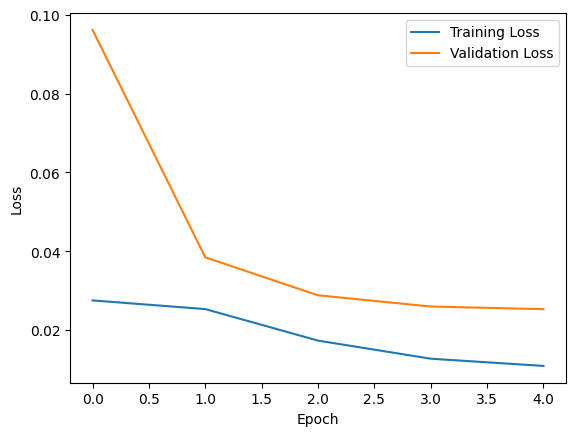

In [6]:
import matplotlib.pyplot as plt

def plot_loss(train_losses, val_losses):
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
plot_loss(train_losses, val_losses)

# 5 - Create OpenCV Detection Function

In [26]:
import cv2
import torch
import numpy as np
from torchvision import transforms
from PIL import Image

# Load the trained model
model = SimpleCNN()
model.load_state_dict(torch.load('Models/model_CNN.pth'))
model.eval()

def detect_face(frame, model):
    # Preprocess the frame
    img = cv2.resize(frame, (120, 120))
    img = Image.fromarray(img)  # Convert numpy array to PIL Image
    transform = transforms.Compose([
        transforms.ToTensor(),
        # Add any other necessary transformations
    ])
    img = transform(img)
    img = img.unsqueeze(0)  # Add batch dimension

    # Run the model
    with torch.no_grad():
        output = model(img)
        

    # Post-process the output (assuming bounding box coordinates and class)
    # Extract class and bounding box coordinates from the output tensor
    pred_class = int(output[0, 0])
    bbox = list(map(float, output[0, 1:].tolist()))
    print(bbox[3])
    print(pred_class)
    

    # Draw bounding box only if the predicted class is 0
    if pred_class == 0:
        print(f"Class: {pred_class}, Bbox: {bbox}")
    
        bbox = [int(coord * frame.shape[1]) for coord in bbox]  # Scale coordinates

        cv2.rectangle(frame, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 2)

    return frame

# Open a webcam
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Detect face
    frame = detect_face(frame, model)

    # Display the resulting frame
    cv2.imshow('Face Detection', frame)

    if cv2.waitKey(1) & 0xFF == 27:  # Press 'Esc' to exit
        break

# Release the capture
cap.release()
cv2.destroyAllWindows()

0.40755990147590637
0
Class: 0, Bbox: [0.3421139419078827, 0.07567517459392548, 0.5442889332771301, 0.40755990147590637]
0.3658097982406616
0
Class: 0, Bbox: [0.3251141607761383, 0.06772805750370026, 0.4948144853115082, 0.3658097982406616]
0.3068058490753174
0
Class: 0, Bbox: [0.28255078196525574, 0.05155472457408905, 0.4165429472923279, 0.3068058490753174]
0.2817403972148895
0
Class: 0, Bbox: [0.2634199559688568, 0.02539222128689289, 0.3884181082248688, 0.2817403972148895]
0.26914697885513306
0
Class: 0, Bbox: [0.2544460892677307, 0.042861759662628174, 0.3587072491645813, 0.26914697885513306]
0.2485615313053131
0
Class: 0, Bbox: [0.27551960945129395, 0.042612142860889435, 0.3453771770000458, 0.2485615313053131]
0.2567676901817322
0
Class: 0, Bbox: [0.29819783568382263, 0.028986746445298195, 0.37027934193611145, 0.2567676901817322]
0.25344741344451904
0
Class: 0, Bbox: [0.3020373284816742, 0.04773062467575073, 0.36300748586654663, 0.25344741344451904]
0.22180481255054474
0
Class: 0, Bb

KeyboardInterrupt: 